In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from veccs import orderings
import pickle
from batram.base_functions import compute_scale

In [2]:
def extract_utils(dataname: str):
    if dataname == 'lr900':
        models_history = torch.load("../results/models_LST30_SQT100.pt")
        with open("../data/LR900ExpLST30SIGSQT10.pkl", "rb") as f:
            data = pickle.load(f)
    else:
        models_history = torch.load("../results/modelsNR_LST30_SQT100.pt")
        with open("../data/NR900ExpLST30SIGSQT10.pkl", "rb") as f:
            data = pickle.load(f)
    shrink_models = models_history["shrink_models"]

    locs = data["locs"]
    locsorder = data["order"]
    gp = data["gp"]
    torchdata = data["data"][:, locsorder]
    nn = orderings.find_nns_l2(locs, 30)

    nTrain = models_history["numSamples"]

    reps = int(len(shrink_models) / len(nTrain))
    nugget_shrink_factors = torch.zeros((len(nTrain), reps))
    for i, _ in enumerate(nTrain):
        for j in range(reps):
            with torch.no_grad():
                nugget_shrink_factors[i, j] = shrink_models[i*reps + j].nugget_shrinkage_factor.exp()
    
    sigmas = torch.zeros((locs.shape[0], len(nTrain), reps))
    for i, _ in enumerate(nTrain):
        for j in range(reps):
            with torch.no_grad():
                sigmas[:, i, j] = shrink_models[i*reps + j].kernel._sigmas(compute_scale(shrink_models[i*reps + j].data.locs, shrink_models[i*reps + j].data.conditioning_sets))

    tm_logscore = models_history["tm_logscore"]
    shrink_logscore = models_history["shrink_logscore"]

    return nTrain, sigmas, nugget_shrink_factors, tm_logscore, shrink_logscore, data, models_history

In [3]:
dataname = 'lr900'
nTrain_lr, sigmas_lr, nugget_shrink_factors_lr, tm_logscore_lr, shrink_logscore_lr, data_lr, models_history_lr = extract_utils(dataname)
dataname = 'nr900'
nTrain_nr, sigmas_nr, nugget_shrink_factors_nr, tm_logscore_nr, shrink_logscore_nr, data_nr, models_history_nr = extract_utils(dataname)

/home/anirban0451/miniconda3/envs/shrink2param/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
mean_nug_shrink_lr = nugget_shrink_factors_lr.mean(dim=1)
median_nug_shrink_lr = nugget_shrink_factors_lr.median(dim=1).values
max_nug_shrink_lr = nugget_shrink_factors_lr.max(dim=1).values
min_nug_shrink_lr = nugget_shrink_factors_lr.min(dim=1).values

mean_nug_shrink_nr = nugget_shrink_factors_nr.mean(dim=1)
median_nug_shrink_nr = nugget_shrink_factors_nr.median(dim=1).values
max_nug_shrink_nr = nugget_shrink_factors_nr.max(dim=1).values
min_nug_shrink_nr = nugget_shrink_factors_nr.min(dim=1).values

sigmas_mean_lr = sigmas_lr.mean(dim=-1)
sigmas_min_lr = sigmas_lr.min(dim=-1).values
sigmas_max_lr = sigmas_lr.max(dim=-1).values

sigmas_mean_nr = sigmas_nr.mean(dim=-1)
sigmas_min_nr = sigmas_nr.min(dim=-1).values
sigmas_max_nr = sigmas_nr.max(dim=-1).values

linestl = ['-', '--', '-.', ':', (5, (10, 3))]
locstoplot = [1, 9, 29, 99, 899]

assert nTrain_lr == nTrain_nr
nTrain = nTrain_lr

In [5]:
sigmas_lr[1:,:].shape

torch.Size([899, 11, 10])

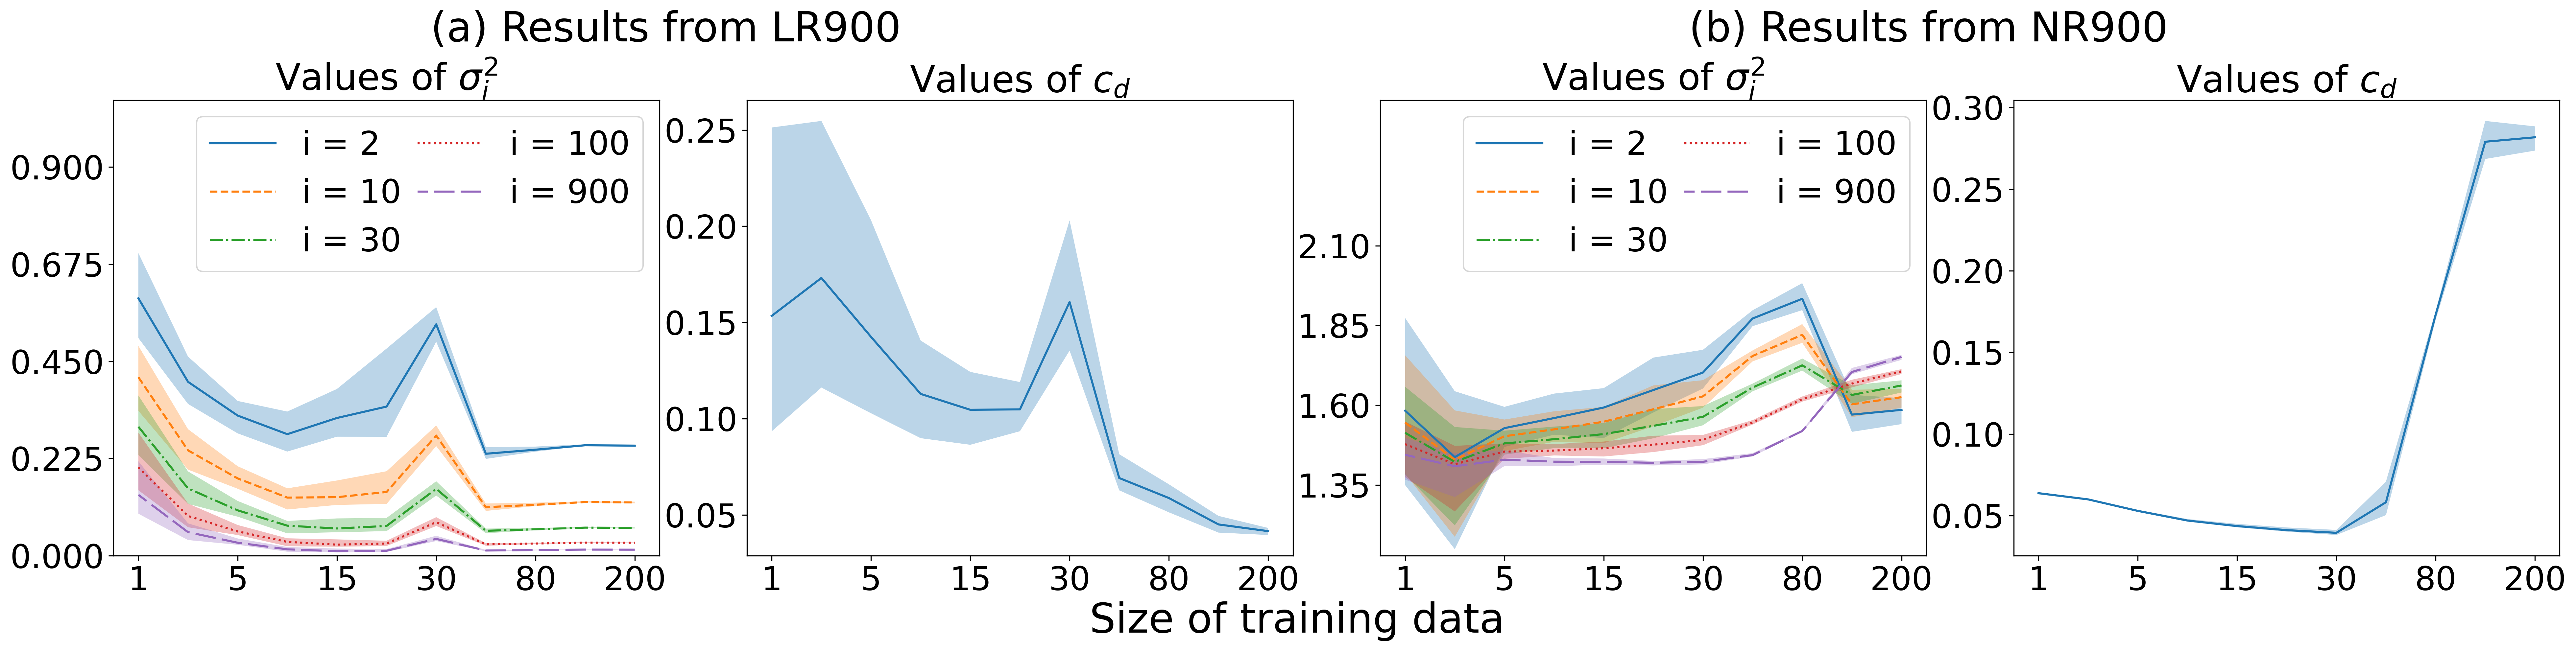

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(32, 6), dpi=300)
fig.subplots_adjust(wspace=0.16)
for i, _i in enumerate(locstoplot):
    ax[0].plot(torch.arange(len(nTrain)), sigmas_mean_lr[_i, :], label=f"i = {_i + 1}", linestyle=linestl[i])
    ax[0].fill_between(torch.arange(len(nTrain)), sigmas_min_lr[_i, :], sigmas_max_lr[_i, :], alpha=0.3)
    #ax[0].set_xticks(torch.arange(len(nTrain)), nTrain, fontsize=18)
    #ax[0].set_xlabel("Size of training data", fontsize=18)
ax[0].legend(fontsize=24, ncols = 2, columnspacing=0.5)
ax[0].set_yticks(torch.linspace(sigmas_lr.min().round(decimals=1), sigmas_lr.max().round(decimals=1), 5))
ax[0].set_ylim(0, sigmas_lr.max() + 0.2)
ax[0].set_title(f"Values of $\sigma^2_i$", fontsize=27)

ax[1].plot(torch.arange(len(nTrain)), mean_nug_shrink_lr)
ax[1].fill_between(torch.arange(len(nTrain)), min_nug_shrink_lr, max_nug_shrink_lr, alpha=0.3)
#ax[1].set_xticks(torch.arange(len(nTrain)), nTrain, fontsize=18)
#ax[1].set_xlabel("Size of training data", fontsize=18)
ax[1].set_title("Values of $c_d$", fontsize=27)

for i, _i in enumerate(locstoplot):
    ax[2].plot(torch.arange(len(nTrain)), sigmas_mean_nr[_i, :], label=f"i = {_i + 1}", linestyle=linestl[i])
    ax[2].fill_between(torch.arange(len(nTrain)), sigmas_min_nr[_i, :], sigmas_max_nr[_i, :], alpha=0.3)
    #ax[2].set_xticks(torch.arange(len(nTrain)), nTrain, fontsize=18)
    #ax[2].set_xlabel("Size of training data", fontsize=18)
ax[2].legend(fontsize=24, ncols = 2, columnspacing=0.5)
ax[2].set_yticks(torch.round(torch.linspace(sigmas_nr.min().round(decimals=1), sigmas_nr.max().round(decimals=1), 5), decimals =2))
ax[2].set_ylim(sigmas_nr.min(), sigmas_nr.max() + 0.5)
ax[2].set_title(f"Values of $\sigma^2_i$", fontsize=27)

ax[3].plot(torch.arange(len(nTrain)), mean_nug_shrink_nr)
ax[3].fill_between(torch.arange(len(nTrain)), min_nug_shrink_nr, max_nug_shrink_nr, alpha=0.3)
#ax[3].set_xticks(torch.arange(len(nTrain)), nTrain, fontsize=18)
#ax[3].set_xlabel("Size of training data", fontsize=18)
ax[3].set_title("Values of $c_d$", fontsize=27)

for i in range(4):
    ax[i].tick_params(axis='both', labelsize=24)
    ax[i].set_xticks(torch.arange(0, len(nTrain), 2), [nTrain[_i] for _i in torch.arange(0, len(nTrain), 2)])

fig.text(0.5, -0.02, 'Size of training data', ha='center', fontsize=30)
fig.text(0.3, 0.98, '(a) Results from LR900', ha='center', fontsize=30)
fig.text(0.7, 0.98, '(b) Results from NR900', ha='center', fontsize=30)

plt.savefig("../plots/sim_shrinkages.pdf", bbox_inches='tight')

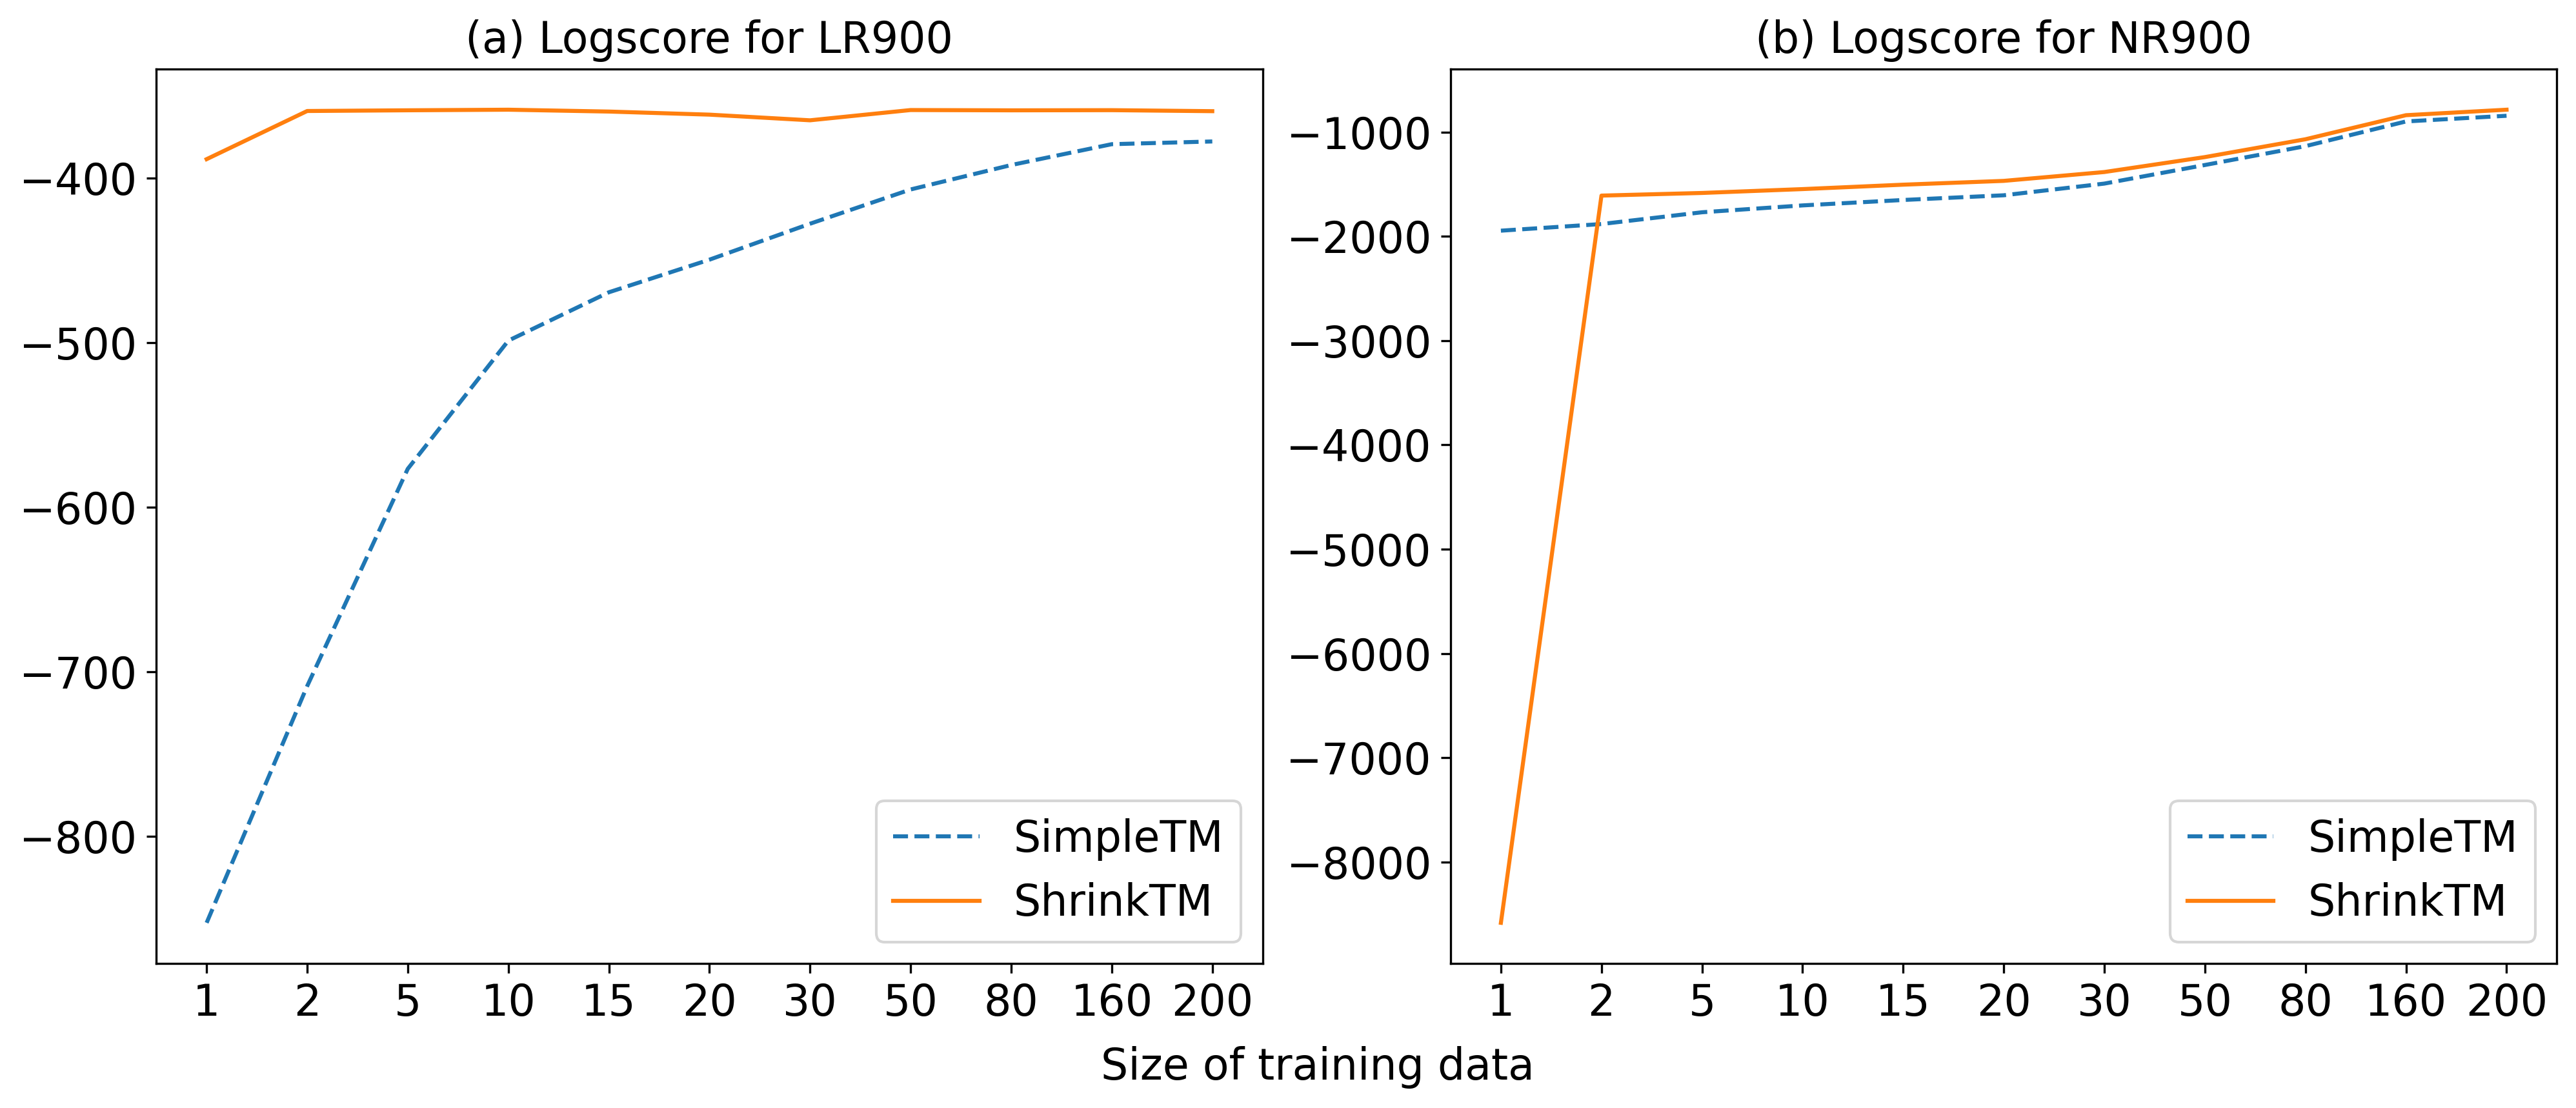

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), dpi=300)

ax[0].plot(torch.arange(len(nTrain)), tm_logscore_lr.mean(dim=0), linestyle = "dashed", label="SimpleTM")
ax[0].plot(torch.arange(len(nTrain)), shrink_logscore_lr.mean(dim=0), label="ShrinkTM")
ax[0].set_xticks(torch.arange(len(nTrain)), nTrain)

ax[1].plot(torch.arange(len(nTrain)), tm_logscore_nr.mean(dim=0), linestyle = "dashed", label="SimpleTM")
ax[1].plot(torch.arange(len(nTrain)), shrink_logscore_nr.mean(dim=0), label="ShrinkTM")
ax[1].set_xticks(torch.arange(len(nTrain)), nTrain)
ax[0].set_title("(a) Logscore for LR900", fontsize = 16)
ax[1].set_title("(b) Logscore for NR900", fontsize = 16)

for i in range(2):
    ax[i].legend(loc = "lower right", fontsize=16)
    ax[i].tick_params(axis='both', labelsize=16)
fig.text(0.5, 0.01, 'Size of training data', ha='center', fontsize=16);
fig.subplots_adjust(wspace=0.17)

plt.savefig("../plots/sim_logscore.pdf", bbox_inches='tight')
    

In [3]:
dataname = 'nr900'
nTrain, sigmas, nugget_shrink_factors, tm_logscore, shrink_logscore, data, models_history = extract_utils(dataname)


/home/anirban0451/miniconda3/envs/shrink2param/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
torchdata = data['data']
locsorder = data['order']


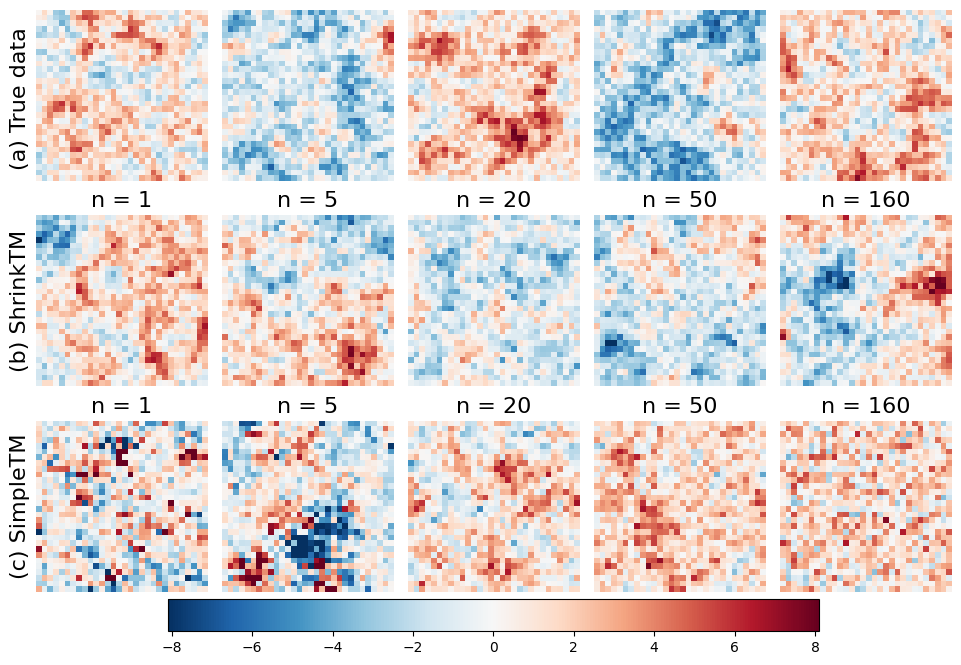

In [20]:

np.random.seed(2024)
Nplots = [1, 5, 20, 50, 160]
indices = np.random.choice(range(100), len(Nplots))
vmax = torchdata[indices, :].abs().max()#torchdata[indices, :].min()
vmin = -vmax#torchdata[indices, :].max()
fig, ax = plt.subplots(3, len(Nplots), figsize=(12, 9))


NplotswithinN = [nTrain.index(N) for N in Nplots]
tm_models = models_history["tm_models"]
shrink_models = models_history["shrink_models"]
reps = len(tm_models) / len(nTrain)
samplestoplot = torch.zeros(2, len(Nplots), 30*30)

np.random.seed(20)
for i, N in enumerate(NplotswithinN):
    samplestoplot[1, i, :] = tm_models[int(reps*N) + 3].cond_sample()
    samplestoplot[0, i, :] = shrink_models[int(reps*N) + 3].cond_sample()
samplestoplot = samplestoplot[:, :, locsorder.argsort()]

fig.subplots_adjust(wspace = 0.001)
for i in range(len(Nplots)):
    ax[0, i].imshow(torchdata[i, :].reshape(30, 30), cmap="RdBu_r", vmin = vmin, vmax =vmax)
    ax[0, i].set_axis_off()
ax[0, 0].text(-5, 15, "(a) True data", fontsize=16, rotation=90, va = "center")

for i in range(0,len(NplotswithinN)):
    ax[1, i].imshow(samplestoplot[0, i, :].reshape(30, 30), cmap="RdBu_r", vmin = vmin, vmax =vmax)
    ax[1, i].set_axis_off()
    ax[1, i].set_title(f"n = {Nplots[i]}", fontsize=16)
ax[1, 0].text(-5, 14.5, "(b) ShrinkTM", fontsize=16, rotation=90, va = "center")

for i in range(0,len(NplotswithinN)):
    ax[2, i].imshow(samplestoplot[1, i, :].reshape(30, 30), cmap="RdBu_r", vmin = vmin, vmax =vmax)
    ax[2, i].set_axis_off()
    ax[2, i].set_title(f"n = {Nplots[i]}", fontsize=16)
ax[2, 0].text(-5, 14.5, "(c) SimpleTM", fontsize=16, rotation=90, va = "center")

fig.colorbar(ax[2, i].imshow(torchdata[i, locsorder.argsort()].reshape(30, 30), cmap="RdBu_r", vmin = vmin, vmax = vmax), 
             ax=ax, orientation="horizontal", shrink = 0.7, pad = 0.01)
fig.savefig(f"../plots/{dataname}_samples_all.pdf", bbox_inches = "tight")

In [6]:
Nplots = [1, 5, 20, 50, 80]
NplotswithinN = [nTrain.index(N) for N in Nplots]
tm_models = models_history["tm_models"]
reps = len(tm_models) / len(nTrain)
Nplots = [1, 5, 20, 50, 80]
samplestoplot = torch.zeros(2, len(Nplots), 30*30)

np.random.seed(20)
for i, N in enumerate(NplotswithinN):
    samplestoplot[1, i, :] = tm_models[int(reps*N)].cond_sample()
    samplestoplot[0, i, :] = shrink_models[int(reps*N)].cond_sample()